# Problem \# 1: Reinforcement Learning

#### Author: Fan Lu
#### Date: 04/25/2023

In [15]:
# All the necessary Python modules are imported here.
import numpy as np
import random

import gym
import tensorflow as tf
from tensorflow.keras import layers

# used to generate GIFs
from gym_to_gif import save_gym_gifs

# used for constructing replay buffer
from collections import deque

# Used to import images and display them
from IPython.display import Image

from matplotlib import animation

import matplotlib
import matplotlib.pyplot as plt

# renders the figure in a notebook and stored in the notebook
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [25, 5]

# Get Library Versions
print('\n'.join(f'{m.__name__}=={m.__version__}' 
                for m in globals().values() if getattr(m, '__version__', None)))

numpy==1.23.5
gym==0.19.0
tensorflow==2.10.1
matplotlib==3.5.2


# Construct Pendulum Environment

We are trying to solve the classic Inverted Pendulum control problem. In this setting, we can take only two actions: swing left or swing right. We have to select from infinite actions ranging from -2 to +2.

Note that Pendulum-v0 is depreciate for gym version >= 0.20.0

In [2]:
problem = "Pendulum-v0"
env = gym.make(problem)

num_states = env.observation_space.shape[0]
print("Size of State Space: {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space: {}".format(num_states))

lower_bound = env.action_space.low[0]
upper_bound = env.action_space.high[0]

print("Min Value of Action: {}".format(lower_bound))
print("Max Value of Action: {}".format(upper_bound))

Size of State Space: 3
Size of Action Space: 3
Min Value of Action: -2.0
Max Value of Action: 2.0


In [3]:
env.action_space.sample()

array([1.8793057], dtype=float32)

To implement better exploration by the Actor network, Ornstein-Uhlenbeck process is used for noisy perturbations, as described in the DDPG paper. It samples noise from a correlated normal distribution and parameters are updated according to:

$$dx_t = -\theta (\mu - x_t) dt + \sigma d W_t$$

For the reasons that:
1. Continuity and smoothness: this helps stablize the training process of the actor network by preventing rapid and abrupt changes in actions.
2. The Ornstein-Uhlenbeck process is an autocorrelated process, meaning that the noise at the current time step is correlated with the noise at the previous time step. This autocorrelation helps in generating temporally consistent noise, which can be beneficial in reinforcement learning tasks where the dynamics of the environment change over time. The temporal consistency of the noise can help the actor network to learn and adapt to changing dynamics more effectively.

In [4]:
class OUActionNoise(object):
    def __init__(self, mean, std_dev, theta = 0.15, dt = 1e-2, x_init = None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_dev
        self.dt = dt
        self.x_init = x_init
        self.reset()
        
    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size = self.mean.shape)
        )
        # Store x into x_prev
        self.x_prev = x
        return x
    
    def reset(self):
        if self.x_init is not None:
            # if initial value is specified, set this initial value.
            self.x_prev = self.x_init
        else:
            # reset parameters to zero vectors
            self.x_prev = np.zeros_like(self.mean)

## Replay Buffer

In [5]:
class Buffer(object):
    def __init__(self, buffer_size=int(1e5), batch_size=64):
        # construct a queue as replay buffer with max size of buffer_size
        self.buffer = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    # strore transition (s, a, r, s') tuple into replay buffer
    def push(self, obs_tuple):
        state, action, reward, next_state = obs_tuple
        # add extra dim that serves as batch dim
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)

        self.buffer.append((state, action, reward, next_state))

    def sample(self):
        # return a batch of trainsions
        # not that when the number of trainsitions is smaller than batch size,
        # it will return all the trainsitions in the buffer
        states, actions, rewards, next_states = zip(*random.sample(self.buffer, self.batch_size))
        # convert to numy array, with the first dim as batch dim
        states = np.concatenate(states)
        actions = np.concatenate(actions).reshape(-1, 1)
        rewards = np.array(rewards).reshape(-1, 1)
        next_states = np.concatenate(next_states)

        # convert to tensors
        state_batch = tf.convert_to_tensor(states, dtype=tf.float32)
        action_batch = tf.convert_to_tensor(actions, dtype=tf.float32)
        reward_batch = tf.convert_to_tensor(rewards, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(next_states, dtype=tf.float32)

        return state_batch, action_batch, reward_batch, next_state_batch

    def __len__(self):
        # return the size of the buffer
        return len(self.buffer)

## Definition of Actor and Critic Networks

Here we define the Actor and Critic networks. These are basic Dense models with ReLU activation.

Note: We need the initialization for last layer of the Actor to be between -0.003 and 0.003 as this prevents us from getting 1 or -1 output values in the initial stages, which would squash our gradients to zero, as we use the tanh activation.

In [6]:
def get_actor():
    # initialize weights between -3e-3 and 3e-3
    last_init = tf.random_uniform_initializer(minval = -3e-3, maxval = 3e-3)
    
    inputs = layers.Input(shape = (num_states,))
    out = layers.Dense(256, activation = "relu")(inputs)
    out = layers.Dense(256, activation = "relu")(out)
    outputs = layers.Dense(1, activation = "tanh", kernel_initializer = last_init)(out)
    
    # out upper bound is 2.0 for Pendulum
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    
    return model

def get_critic():
    # state as input
    state_input = layers.Input(shape = (num_states))
    state_out = layers.Dense(16, activation = "relu")(state_input)
    state_out = layers.Dense(32, activation = "relu")(state_out)    
    
    # action as input
    action_input = layers.Input(shape = (num_actions))
    action_out = layers.Dense(32, activation = "relu")(action_input)
    
    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])
    
    out = layers.Dense(256, activation = "relu")(concat)
    out = layers.Dense(256, activation = "relu")(out)
    outputs = layers.Dense(1)(out)
    
    # Outputs single value for given state-action pair
    model = tf.keras.Model([state_input, action_input], outputs)
    
    return model

## DDPG Class
Deep Deterministic Policy Gradient (DDPG) is a model-free off-policy algorithm for learning continous actions.

It combines ideas from DPG (Deterministic Policy Gradient) and DQN (Deep Q-Network). It uses Experience Replay and slow-learning target networks from DQN, and it is based on DPG, which can operate over continuous action spaces.

### Critic Loss Function:
$$y_i = r_i + Q^\prime (s_{i+1}, \mu^\prime(s_{i+1}|\theta^{\mu^\prime}) | \theta^{Q^\prime})$$
$$\text{Loss} = \frac{1}{N} \sum_i (y_i - Q(s_i, a_i | \theta^Q))$$

## Actor Loss Function:
The objective is to maximize the expected return:
$$J(\theta) = \mathbb{E}[Q(s, a) |_{s = s_t, a_t = \mu(s_t)}]$$
Policy Loss (Applying chain rule):
$$\nabla_{\theta^\mu} J(\theta) \approx \nabla_a Q(s, a) \nabla_{\theta^{\mu} \mu(s|\theta^\mu)}$$
Since we are updating the policy in an off-policy way with batches of experience, we take the mean of the sum of gradients calculated from the mini-batch:
$$\nabla_{\theta^\mu} J(\theta) \approx \frac{1}{N}\sum_i [\nabla_a Q(s, a| \theta^Q)|_{s = s_i, a = \mu(s_i)} \nabla_{\theta^{\mu}} \mu(s|\theta^\mu)|_{s=s_i}]$$

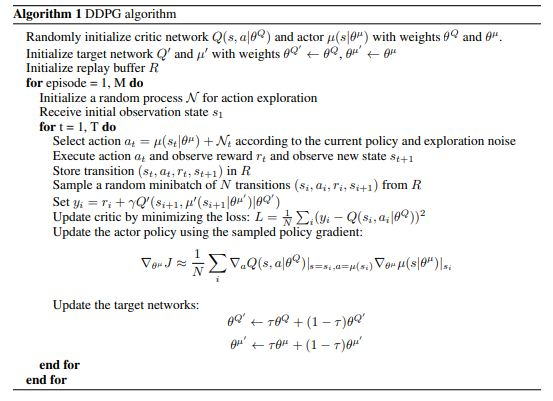

In [13]:
Image("data/ddpg.jpg")

In [8]:
class DDPG(object):
    def __init__(self, gamma, tau, actor_lr, critic_lr, std_dev, 
                     buffer_size = int(1e5), batch_size = 64, GPU = False):
        # discount factor
        self.gamma = gamma
        # soft update
        self.tau = tau
        
        # replay buffer
        self.buffer = Buffer(buffer_size, batch_size)
        # noise function used for exploration policy
        self.ou_noise = OUActionNoise(mean = np.zeros(1), std_dev = float(std_dev) * np.ones(1))
        
        # construct actor and critic networks
        self.actor, self.critic = get_actor(), get_critic()
        # construct target actor and critic networks
        self.target_actor, self.target_critic = get_actor(), get_critic()

        # making the weights equal initially
        self.target_actor.set_weights(self.actor.get_weights())
        self.target_critic.set_weights(self.critic.get_weights())
        
        # initialize optimizer used for optimizing actor and critic networks
        self.actor_optimizer = tf.keras.optimizers.Adam(actor_lr)
        self.critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
        
        # Use GPU?
        if GPU and tf.config.list_physical_devices('GPU') is not None:
            tf.debugging.set_log_device_placement(True)
            print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
    
    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one
    @tf.function
    def update(self, state_batch, action_batch, reward_batch, next_state_batch):
        # training and updating actor critic networks
        with tf.GradientTape() as tape:
            target_actions = self.target_actor(next_state_batch, training = True)
            y = reward_batch + self.gamma * self.target_critic(
                [next_state_batch, target_actions], training = True
            )
            critic_value = self.critic([state_batch, action_batch], training = True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))
            
            critic_grad = tape.gradient(critic_loss, self.critic.trainable_variables)
            self.critic_optimizer.apply_gradients(
                zip(critic_grad, self.critic.trainable_variables)
            )
        # training and updating actor critic networks
        with tf.GradientTape() as tape:
            actions = self.actor(state_batch, training = True)
            critic_value = self.critic([state_batch, actions], training = True)
            # used '-value' as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)
            actor_grad = tape.gradient(actor_loss, self.actor.trainable_variables)
            self.actor_optimizer.apply_gradients(
                zip(actor_grad, self.actor.trainable_variables)
            )
    
    # we compute the loss and update parameters
    def learn(self):
        # Get a batch of trainsitions from replay buffer
        state_batch, action_batch, reward_batch, next_state_batch = agent.buffer.sample()
        
        # update parameters of actor and critic networks
        self.update(state_batch, action_batch, reward_batch, next_state_batch)
        # soft update of target networks
        self.update_target()
    
    # Exporation policy returns an action sampled from our Actor network plus some noise for exploration.
    def exp_policy(self, state):
        # convert state into tensor
        state = tf.expand_dims(tf.convert_to_tensor(state), 0)
        # get an action from actor
        sampled_actions = tf.squeeze(self.actor(state))
        # adding noise to action
        sampled_actions = sampled_actions.numpy() + self.ou_noise()

        # make sure action is within bounds
        legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

        return [np.squeeze(legal_action)]
    
    # policy used after testing
    def act(self, state):
        # convert state into tensor
        state = tf.expand_dims(tf.convert_to_tensor(state), 0)
        # get an action from actor
        action = tf.squeeze(self.actor(state, training = False))
        # make sure action is within bounds
        legal_action = np.clip(action, lower_bound, upper_bound)

        return [np.squeeze(legal_action)]

    # This update target parameter slowly
    # Based on rate 'tau', which is much less than one.
    @tf.function
    def update_target(self):
        for (a, b) in zip(self.target_actor.variables, self.actor.variables):
            a.assign(b * self.tau + a * (1 - self.tau))
            
        for (a, b) in zip(self.target_critic.variables, self.critic.variables):
            a.assign(b * self.tau + a * (1 - self.tau))

# Training hyperparameters

In [9]:
# standard deviation for OU noise
std_dev = 0.2

# Learning rate for actor and critic models
critic_lr = 0.002
actor_lr = 0.001

# total number of episodes used for training
total_episodes = 100
# dicount factor for future rewards
gamma = 0.99
# used to update target networks
tau = 0.005

# replay buffer size
buffer_size = int(1e5)
# batch size for training
batch_size = 64

# initialize DDPG agent
agent = DDPG(gamma, tau, actor_lr, critic_lr, std_dev, buffer_size, batch_size)

## Training Actor and Critic
Now we implement our main training loop, and iterate over episodes. We sample actions using policy() and train with learn() at each time step, along with updating the Target networks at a rate tau.

In [10]:
# to store reward history of each episode
ep_reward_list = []
# to store average reward history of last few episodes
avg_reward_list = []

# takes about 4 min to train
for ep in range(total_episodes):
    episodic_reward = 0
    state = env.reset()
    
    while True:
        # uncomment this to see the actor in action
        # but not in a python notebook.
        # env.render()
        
        # get an exploration action
        action = agent.exp_policy(state)
        # recieve state and reward from environment.
        next_state, reward, done, info = env.step(action)
        # cumulating rewards
        episodic_reward += reward
        
        # Store current trainsion into replay buffer
        agent.buffer.push((state, action, reward, next_state))
        # update actor, critic, target_actor, target_critic networks
        if agent.buffer.__len__() >= batch_size:
            agent.learn()
        
        # end this episode when done is true
        if done: break
        # transition to the next state
        state = next_state
    
    # store the cumulative rewards
    ep_reward_list.append(episodic_reward)
    # mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    avg_reward_list.append(avg_reward)
    print("\r Epsiode {}/{} Avg Reward: {:.4f}".format(ep + 1, total_episodes, avg_reward), end = "")


 Epsiode 100/100 Avg Reward: -151.9266

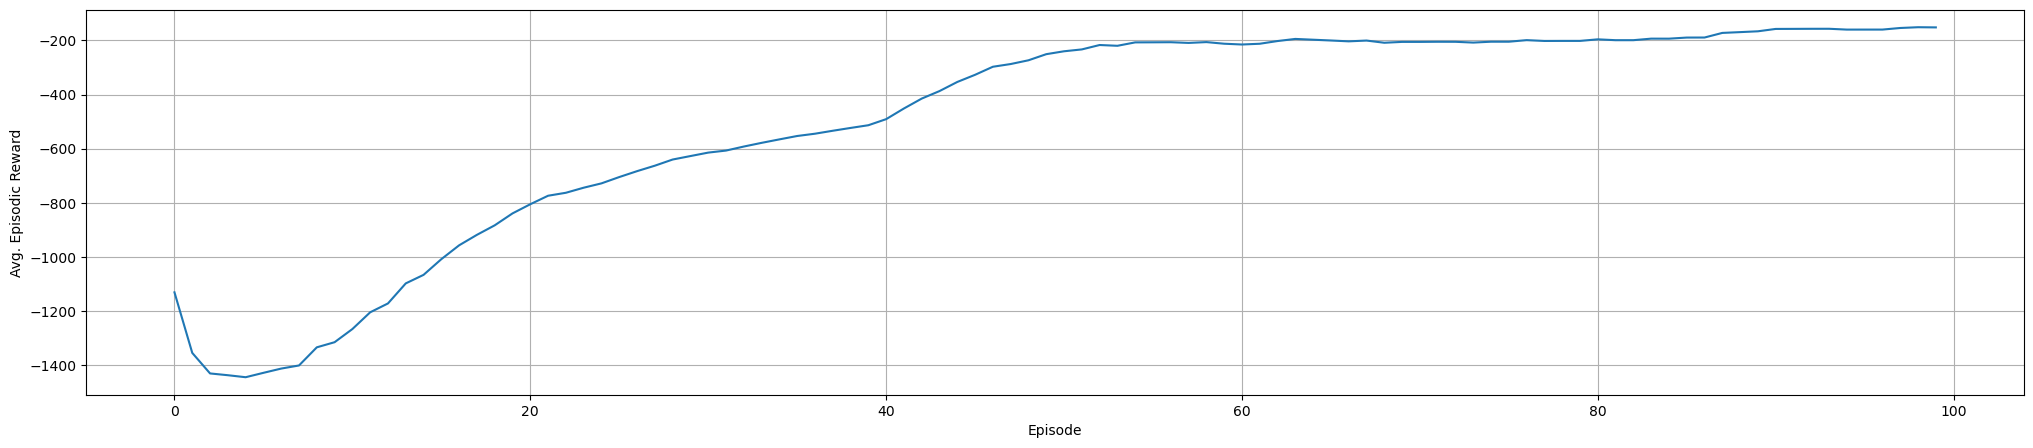

In [11]:
# plotting graph
# episodes versous avg. rewards
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Episodic Reward")
plt.grid(True)
plt.show()

## Testing Learnt policy
### Given more time, will try Polyak-Rupper average to ensure stability

MovieWriter imagemagick unavailable; using Pillow instead.


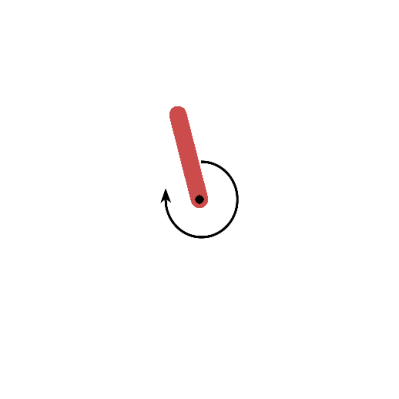

In [16]:
save_gym_gifs('Pendulum-v0', agent)
Image(url='data/gym_animation_Pendulum-v0.gif') 